In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,Callback, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.losses import MeanAbsoluteError
from time import time
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import matplotlib

In [2]:
### Limit to the first GPU for this model
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
image_size =224
batch_size = 200
num_epoches = 3 ## in the paper we trained 50 epochs

In [4]:
### read csvs that contains image filepaths and labels
df_train = pd.read_csv('boneage_train.csv')
df_val = pd.read_csv('boneage_val.csv')
df_test = pd.read_csv('boneage_test.csv')

In [5]:
### display the train csv
### column id is the image id, column 'boneage' is the true bone agle, column is the the sex info
### column img_dir is the filepaths for each image
df_train.head()

,id,boneage,male,img_dir
0,1377,180,False,boneage-training-dataset/1377.png
1,1379,94,False,boneage-training-dataset/1379.png
2,1380,120,True,boneage-training-dataset/1380.png
3,1381,82,False,boneage-training-dataset/1381.png
4,1383,150,True,boneage-training-dataset/1383.png


In [6]:
### data augementation for the training set
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rescale=1./255,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [7]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255)

In [8]:
train_generator = train_data_generator.flow_from_dataframe(
        dataframe=df_train,
        x_col = 'img_dir',
        y_col = 'boneage',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True,
        class_mode='raw')

Found 9647 validated image filenames.


In [9]:
validation_generator = data_generator.flow_from_dataframe(
        dataframe=df_val,
        x_col = 'img_dir',
        y_col = 'boneage',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True,
        class_mode='raw')

Found 1072 validated image filenames.


In [10]:
### pre-trained model directory
model_dir = 'RadImageNet_models/RIN-DenseNet121_notop.h5'

In [11]:
### import the weights from RadImageNet DenseNet121 and compile the model
base_model = DenseNet121(weights=model_dir, input_shape=(image_size, image_size, 3), include_top=False,pooling='avg')
y = base_model.output
y = Dropout(0.4)(y)
predictions = Dense(1, activation='linear')(y)
model = Model(inputs=base_model.input, outputs=predictions)
adam = Adam()
model.compile(optimizer=adam, loss='mean_absolute_error', metrics=[MeanAbsoluteError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [12]:
### specifity training and validation steps
train_steps =  len(train_generator.labels)/ batch_size
val_steps = len(validation_generator.labels) / batch_size

In [13]:
### create a folder to save the models
h5_output_dir = "./saved_models/"
if not os.path.exists(h5_output_dir):
    os.mkdir(h5_output_dir)

In [14]:
### save model with lowest mean absolute error on validation set
filepath = h5_output_dir + "rin-densenet121-sample.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [15]:
history = model.fit_generator(
        train_generator,
        epochs=num_epoches,
        steps_per_epoch=train_steps,
        validation_data=validation_generator,
        validation_steps=val_steps,
        use_multiprocessing=True,
        workers=15,
        callbacks=[checkpoint,tensorboard])

/raid/nfs4/home/meix01/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
48/48 [==============================] - 66s 956ms/step - loss: 123.4086 - mean_absolute_error: 123.4237 - val_loss: 49.7772 - val_mean_absolute_error: 49.6589

Epoch 00001: val_mean_absolute_error improved from inf to 49.65893, saving model to ./saved_models/rin-densenet121-sample.h5
Epoch 2/3
48/48 [==============================] - 48s 813ms/step - loss: 109.6230 - mean_absolute_error: 110.0006 - val_loss: 49.9078 - val_mean_absolute_error: 49.3908

Epoch 00002: val_mean_absolute_error improved from 49.65893 to 49.39079, saving model to ./saved_models/rin-densenet121-sample.h5
Epoch 3/3
48/48 [==============================] - 45s 780ms/step - loss: 90.7983 - mean_absolute_error: 90.7625 - val_loss: 74.0816 - val_mean_absolute_error: 74.2777

Epoch 00003: val_mean_absolute_error did not improve from 49.39079


In [16]:
### save train and validation loss to a csv
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
d_loss = pd.DataFrame({'train_mean_absolute_error':train_mae, 'val_mean_absolute_error':val_mae, 'train_loss':train_loss, 'val_loss':val_loss})
d_loss.to_csv('rin-densenet121-boneage-train-val-loss-sample.csv', index=False)

In [17]:
### load test generator
test_generator = data_generator.flow_from_dataframe(
        dataframe=df_test,
        x_col = 'img_dir',
        y_col = 'boneage',
        target_size=(image_size, image_size),
        batch_size=1,
        shuffle=False,
        class_mode='raw')

Found 1892 validated image filenames.


In [18]:
### load the best saved model for evaluation on the test set
best_model = load_model("./saved_models/rin-densenet121-sample.h5", compile=False)

In [19]:
### generate the prediction on test set
pred = best_model.predict_generator(test_generator,steps=len(test_generator.labels), verbose=1)

/raid/nfs4/home/meix01/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1892/1892 [==============================] - 47s 24ms/step


In [20]:
### get filenames and labels
f = test_generator.filenames
label = test_generator.labels

In [21]:
### change the pred to 1-d list
pred_v = [pred[i][0] for i in range(pred.shape[0])]

In [22]:
### create a dataframe to show the true label and prediction for each image
df = pd.DataFrame({'filename':f,'True bone age':label,'RIN-DenseNet121 prediction':pred_v})

In [23]:
df

,filename,True bone age,RIN-DenseNet121 prediction
0,boneage-training-dataset/1382.png,138,75.462097
1,boneage-training-dataset/1398.png,4,43.706764
2,boneage-training-dataset/1408.png,126,54.798279
3,boneage-training-dataset/1422.png,32,60.629330
4,boneage-training-dataset/1431.png,27,52.790459
...,...,...,...
1887,boneage-training-dataset/15585.png,162,95.275581
1888,boneage-training-dataset/15589.png,84,108.693237
1889,boneage-training-dataset/15597.png,192,95.189980
1890,boneage-training-dataset/15598.png,120,95.080864


In [24]:
### calcualte the mean absolute error on the tset set
mae = abs(df['True bone age'] - df['RIN-DenseNet121 prediction']).mean()
print('Mean absolute error on the test set is ', mae, " months")

Mean absolute error on the test set is  50.541651463596814  months


In [25]:
### Gradient Class Activation Maps
image_width = best_model.input_shape[2]
image_height = best_model.input_shape[1]

In [26]:
""" Please refer to https://keras.io/examples/vision/grad_cam/ for more information"""
def get_heatmap(cnn_model, last_conv_layer_name, img_id):  
    # This is to get the image array data from the test generator
    img_array = test_generator[img_id][0]
    
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model([cnn_model.inputs], [cnn_model.get_layer(last_conv_layer_name).output, cnn_model.output])
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap('gist_heat')

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)

    # Load the original image   
    img = keras.preprocessing.image.load_img(test_generator.filepaths[img_id])
    img = keras.preprocessing.image.img_to_array(img)
    W, H = img.shape[0], img.shape[1]

    # Resize the RGB heatmap to original image size
    jet_heatmap_resize = jet_heatmap.resize((H,W))
    jet_heatmap_resize = keras.preprocessing.image.img_to_array(jet_heatmap_resize) 

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap_resize * 1 + img # 1 is the chosen color density 
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img, preds.numpy()[0][0]

In [27]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}

In [28]:
def get_y_m(age):
    """convert total xxx months to x years and y months"""
    m = age % 12
    y = age // 12
    text =  str(int(y)) + 'y, ' + str(int(round(m,0))) + "m"
    return text

In [29]:
### choose the relu layer for grad-cam
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv3_block2_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_1_relu (Activation (None, 28, 28, 128)  0           conv3_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_2_conv (Conv2D)    (None, 28, 28, 32)   36864       conv3_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block2_concat (Concatenat (None, 28, 28, 192)  0           conv3_block1_concat[0][0]        
                                                                 conv3_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_0_bn (BatchNormali (None, 28, 28, 192)  768         conv3_block2_concat[0][0]        
__________

In [30]:
def plot_cam(img_id):

    img = keras.preprocessing.image.load_img(test_generator.filepaths[img_id])
    img = keras.preprocessing.image.img_to_array(img)
    #print(img.shape)
    
    # Load RadImageNet InceptionV3
    superimposed_img_rin_densenet121,preds_rin_densenet121 = get_heatmap(best_model, 'relu' , img_id)

    fig = plt.figure(figsize=(4,6))
    gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=2)
    
    
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])

    img = keras.preprocessing.image.array_to_img(img)
    t = 'Bone age X-ray '+ str(int(df_test.boneage[img_id]//12))+ "y, " + str(int(round(df_test.boneage[img_id]%12,0))) + "m (male)" 
    ax1.set_title("\n".join(wrap(t,15)), fontsize=14, **font)
    ax1.imshow(img) #original
    ax1.axis('off')
    
    ax2.set_title(get_y_m(preds_rin_densenet121), fontsize=14, **font)
    ax2.imshow(superimposed_img_rin_densenet121) 
    ax2.axis('off')
   
    plt.tight_layout()
    plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


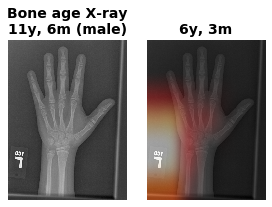

In [31]:
### display the gradient class activation maps
from textwrap import wrap
plot_cam(0)
# for i in range(len(df_test.filename)): ### to show all grad-cams
#     plot_cam(i)